
# Sentiment analysis

This notebook trains a sentiment analysis model to classify customer reviews as positive, negative or neutral based on the text of the review.

You'll use the tbl_labelled_reviews dataset contains more than 460k rewiews.

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from time import time
from shutil import copyfile
import zipfile
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
import string
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
source_path = "/content/drive/MyDrive/marketing analytics/file aggiornati.zip"

In [ ]:
# Extract file: tbl_customer_review
t0 = time()
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_labelled_reviews.csv')
print("File extraction completed in %0.3f seconds" % (time() - t0))

File extraction completed in 4.827 seconds


In [ ]:
# File path of the extracted 'tbl_customers.csv' file
csv_file_path = "tbl_labelled_reviews.csv"
tbl_labelled_reviews = pd.read_csv(csv_file_path)

In [ ]:
tbl_labelled_reviews['review_text'].values[2:3]

array(["I sent these to my dad for his bday and he said they were really pretty good. He's hard to buy for so that says a lot :)"],
      dtype=object)

In [ ]:
tbl_labelled_reviews['review_length']=tbl_labelled_reviews['review_text'].apply(lambda x:len(x))
tbl_labelled_reviews.groupby("sentiment_label").agg(mean_lenght= ('review_length', 'median')).reset_index(False)

,sentiment_label,mean_lenght
0,negative,338.0
1,neutral,353.0
2,positive,277.0


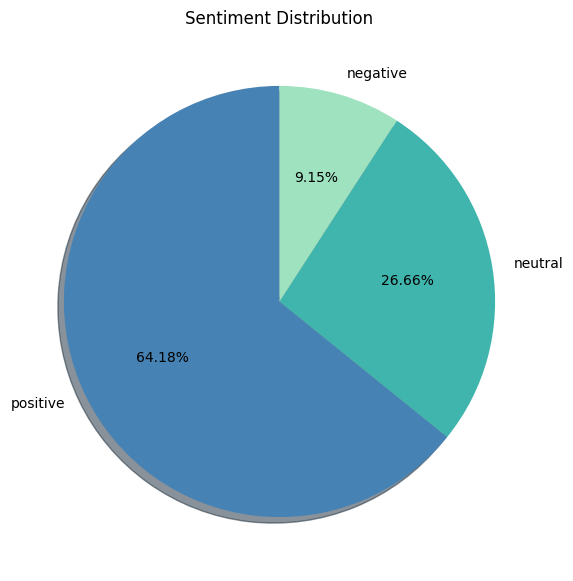

In [ ]:
label_cal =tbl_labelled_reviews['sentiment_label'].value_counts(sort = True).index
size_cal= tbl_labelled_reviews['sentiment_label'].value_counts(sort = True)

plt.figure(figsize=(20, 7))
plt.title('Sentiment Distribution')
plt.pie(size_cal, labels=label_cal, startangle=90, shadow=1, autopct='%1.2f%%', colors=['#4682B4', '#40B5AD', '#9FE2BF'])
plt.show()

# prepocessing

We process the textual data stored in 'review_text' by converting it to lower case, removing URLs, tags, punctuation, numbers and common English stopwords. After displaying the most frequent words for each sentiment category with a word cloud visualisation, we convert the categorical sentiment labels into numerical values to prepare the data for training the BERT model.

In [ ]:
def custom_standardization(input_data):
    # Convert to lowercase
    lowercase = input_data.lower()

    # Remove URLs
    without_urls = re.sub(r'http\S+', ' ', lowercase)

    # Remove HTML tags like "<br />"
    stripped_html = re.sub("<br\s*/?>", " ", without_urls)


    # Remove punctuation
    punctuation_regex = f"[{re.escape(string.punctuation)}]"
    cleaned_text = re.sub(punctuation_regex, "", stripped_html)
    # Remove numbers
    cleaned_text = re.sub(r'\d+', '', cleaned_text)

    # Remove sequences containing digits and word characters
    cleaned_text = re.sub(r'\w*\d\w*', '', cleaned_text)

    return cleaned_text

# Assuming "review_text" is the column containing the review text
tbl_labelled_reviews['review_text_cleaned'] = tbl_labelled_reviews['review_text'].apply(custom_standardization)
# Remove stop words for each review_text_cleaned
stop = stopwords.words('english')


tbl_labelled_reviews['review_text_cleaned'] = tbl_labelled_reviews['review_text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
pd.set_option('display.max_colwidth', None)
tbl_labelled_reviews['review_text'].head(5)

0                                                                                                                                  I'm no bitters expert but I bought it as a gift for a friend.  I was surprised when I heard that this was anise flavored because neither of us are fans of licorice flavored things and I wish the description had mentioned that.  I might have choosen another brand that didn't have that flavor.
1                                                                                                                                                                                                                                                                                                              these are probably great in the right drinks, but i dont like them at all in an old fashioned. i'll stick with angostura
2                                                                                                                                                       

In [ ]:
pd.set_option('display.max_colwidth', None)
tbl_labelled_reviews['review_text_cleaned'].head(5)

0                                                                                                              im bitters expert bought gift friend surprised heard anise flavored neither us fans licorice flavored things wish description mentioned might choosen another brand didnt flavor
1                                                                                                                                                                                                                       probably great right drinks dont like old fashioned ill stick angostura
2                                                                                                                                                                                                                                   sent dad bday said really pretty good hes hard buy says lot
3                                                                     purchased gift family member loves bbq pork warned never tried try

In [ ]:
# We calculate the median text length of the column 'review_text_cleaned', which will be useful for the next tasks
print("Median text length:", tbl_labelled_reviews['review_text_cleaned'].apply(len).median())

Median text length: 182.0


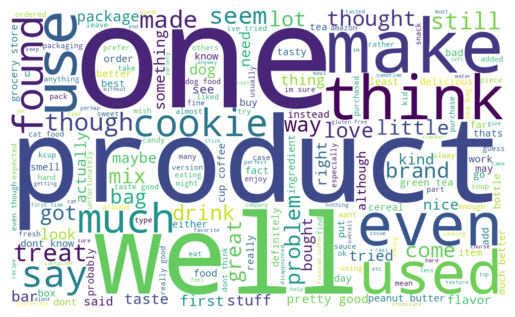

In [ ]:
# Filter rows where the sentiment_label is equal to 'neutral'
neutral_reviews = tbl_labelled_reviews.loc[tbl_labelled_reviews['sentiment_label'] == 'neutral', 'review_text_cleaned']

# Concatenate all neutral reviews into a single string
text = ' '.join(neutral_reviews)

# Create and generate a word cloud image:

wc= WordCloud( background_color= "white",
               mode='RGB',
               max_words=200,
              height=600,
               width= 1000).generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

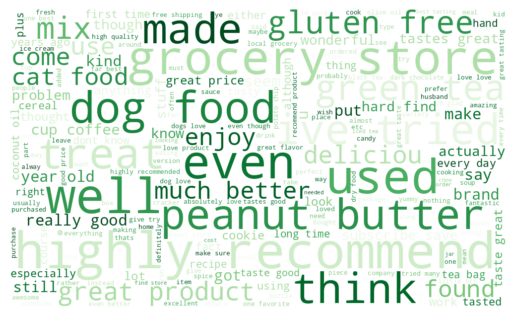

In [ ]:
# Filter rows where the sentiment_label is equal to 'positive'
positive_reviews = tbl_labelled_reviews.loc[tbl_labelled_reviews['sentiment_label'] == 'positive', 'review_text_cleaned']

# Concatenate all positive reviews into a single string
text = ' '.join(positive_reviews)

# Create and generate a word cloud image:

wc= WordCloud( background_color= "white",
               mode='RGB',
               max_words=200,
              height=600,
               width= 1000,
               colormap='Greens').generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

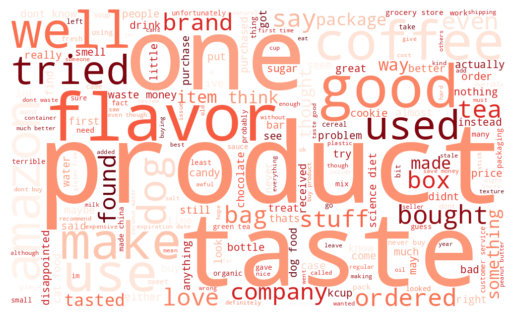

In [ ]:
# Filter rows where the sentiment_label is equal to 'negative'
negative_reviews = tbl_labelled_reviews.loc[tbl_labelled_reviews['sentiment_label'] == 'negative', 'review_text_cleaned']

# Concatenate all negative reviews into a single string
text = ' '.join(negative_reviews)

# Create and generate a word cloud image:

wc= WordCloud( background_color= "white",
               mode='RGB',
               max_words=200,
              height=600,
               width= 1000,
               colormap='Reds').generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Define a dictionary to map sentiment labels to numeric values
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

# Apply the mapping to the 'sentiment_label' column
tbl_labelled_reviews['numeric_sentiment'] = tbl_labelled_reviews['sentiment_label'].map(sentiment_mapping)


# We drop the columns 'Unnamed: 0', 'labelled_reviews_index'
tbl_labelled_reviews.drop(['Unnamed: 0', 'labelled_reviews_index', 'sentiment_label','review_text'], axis=1, inplace=True)


In [ ]:
tbl_labelled_reviews

,review_text_cleaned,numeric_sentiment
0,im bitters expert bought gift friend surprised heard anise flavored neither us fans licorice flavored things wish description mentioned might choosen another brand didnt flavor,1
1,probably great right drinks dont like old fashioned ill stick angostura,1
2,sent dad bday said really pretty good hes hard buy says lot,2
3,purchased gift family member loves bbq pork warned never tried try putting anything well come find love sauces much asked could find bought try final verdict someone close like bbq anything highyly recomend giving try,2
4,wife bought sauce sampler christmas knowing love bbq sauces dipping sauces kinds sauces quite delicious best part getting try several different styles ie texas brisket sauce versus carolina mustardbased sauce recommend far taste styles price plus shipping added made quite expensive,1
...,...,...
462739,great sesame chickenthis good better resturants eaten atmy husband loved itwill find recipes use,2
462740,im disappointed flavor chocolate notes especially weak milk thickens flavor still disappoints worth try ill never buy use whats left gone time thanks small cans,1
462741,stars small give one training session tried train dog ceaser dog treats made puppy hyper compare ingredients know little stars basic food ingredients without preservatives food coloring sweet potato flavor also make hand smell like dog food,2
462742,best treats training rewarding dog good grooming lower calories loved doggies sweet potatoes seem favorite wet noses treat,2


To address sentiment class imbalance (64% positive, 9% negative, 26% neutral), we split data into 80% train and 20% validation sets, balancing classes. Labels were one-hot encoded for efficient model training.

In [ ]:
# Shuffle the DataFrame
tbl_labelled_reviews = tbl_labelled_reviews.sample(frac=1)

#  Separate DataFrame for each sentiment label
df_negative = tbl_labelled_reviews[tbl_labelled_reviews['numeric_sentiment'] == 0]
df_neutral = tbl_labelled_reviews[tbl_labelled_reviews['numeric_sentiment'] == 1]
df_positive = tbl_labelled_reviews[tbl_labelled_reviews['numeric_sentiment'] == 2]

# Calculate the number of rows for the train and test sets
train_ratio = 0.8
test_ratio = 0.2

num_train_negative = int(len(df_negative) * train_ratio)
num_train_neutral = int(len(df_neutral) * train_ratio)
num_train_positive = int(len(df_positive) * train_ratio)

# Combine to create train and test sets
train_set = pd.concat([
    df_negative[:num_train_negative],
    df_neutral[:num_train_neutral],
    df_positive[:num_train_positive]
])

val_set = pd.concat([
    df_negative[num_train_negative:],
    df_neutral[num_train_neutral:],
    df_positive[num_train_positive:]
])

# Shuffle the train and test sets
train_set = train_set.sample(frac=1)
val_set = val_set.sample(frac=1)

# Train dataset
train_ds=train_set.review_text_cleaned

# Test dataset
val_ds=val_set.review_text_cleaned

In [ ]:
# One-hot-encoding
from sklearn.preprocessing import OneHotEncoder

train_label=train_set.numeric_sentiment
val_label=val_set.numeric_sentiment

# Apply one-hot encoding to labels
ohe = OneHotEncoder()
train_label_encoded = ohe.fit_transform(np.array(train_label).reshape(-1, 1)).toarray()
val_label_encoded = ohe.transform(np.array(val_label).reshape(-1, 1)).toarray()

print("train_label sample:")
print(train_label[:10])

print("val_label sample:")
print(val_label[:10])

train_label sample:
110852    2
406383    2
234855    2
456888    2
431906    0
329982    2
259350    2
159960    1
67943     2
162963    1
Name: numeric_sentiment, dtype: int64
val_label sample:
47064     2
229560    2
422855    1
115607    2
287681    1
87671     1
184987    2
447734    2
182163    2
56608     2
Name: numeric_sentiment, dtype: int64


# BERT

BERT (Bidirectional Encoders Representations from Transformers) pre-trains bidirectional text models by capturing left and right context. It's fine-tuned with an added layer to excel in diverse NLP tasks. Vocabulary: 30,522 words. We chose BERT-Base-Uncased for its case-insensitivity, computational efficiency, and memory savings compared to BERT- Base-cased.

In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

In [ ]:
# Create a tokenizer instance
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

The maxlen parameter is set to 200 and specifies the maximum length of the tokenized sequences. Texts longer than this length are truncated, and texts shorter than this length are padded. While the attention_mask set to True helps the model distinguish between actual tokens and padded tokens during training. Once the fast_encode function is defined, it's executed on both the training and validation sets, by converting them into tokenized and encoded form

In [ ]:
# Tokenization
#The BertTokenizer takes care of the tokenization process, including WordPiece tokenization, subword tokenization, and converting tokens to token IDs.
def fast_encode(texts, tokenizer, maxlen=180):
    encodings = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=maxlen,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    return encodings['input_ids'], encodings['attention_mask']  # Return input_ids and attention_mask

x_train_ids, x_train_attention = fast_encode(train_ds, tokenizer, maxlen=180)
x_val_ids, x_val_attention = fast_encode(val_ds, tokenizer, maxlen=180)

In [ ]:
print(x_train_ids.shape)
print(x_val_ids .shape)
print(train_label.shape)
print(val_label.shape)
print(x_val_ids.dtype)
print(x_val_ids.dtype)
print(train_label.dtype)
print(val_label.dtype)

(370194, 180)
(92550, 180)
(370194,)
(92550,)
<dtype: 'int32'>
<dtype: 'int32'>
int64
int64


In [ ]:
print("x_train sample:")
print(x_train_ids[1])

print("x_val sample:")
print(x_val_ids[1])

x_train sample:
tf.Tensor(
[  101  2048  2522 10623  2483 12246 19582  2397  3129  2985  2095  2431
  8738  2075  4117  2561  7038 17730 10418 13258  7078  2293 25860  4435
 18452   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0

# Build the model

BERT-Base-Uncased: 12-layers, 768-hidden, 12-attention-heads, 110M parameters


In [ ]:
# Load DistilBERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# We save only the best model
checkpoint_filepath = '/content/drive/MyDrive/marketing analytics/Bert_sent'
mcp_save = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

We use categorical crossentropy as our loss since we're doing softmax classification and the labels are one-hot encoded vectors.

In [ ]:

def build_model(transformer, max_len=180, num_classes=3):
    input_ids = Input(shape=(max_len,), dtype='int32', name='input_ids')
    attention_mask = Input(shape=(max_len,), dtype='int32', name='attention_mask')  # Add attention_mask input

    embeddings = transformer([input_ids, attention_mask])[1]

    x = Dense(256, activation='relu')(embeddings)
    x = Dense(128, activation='relu')(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    opt = Adam(learning_rate=3e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model

In [ ]:
model = build_model(bert_model, max_len=180)

In [ ]:
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 180)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 180)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 180,                                           

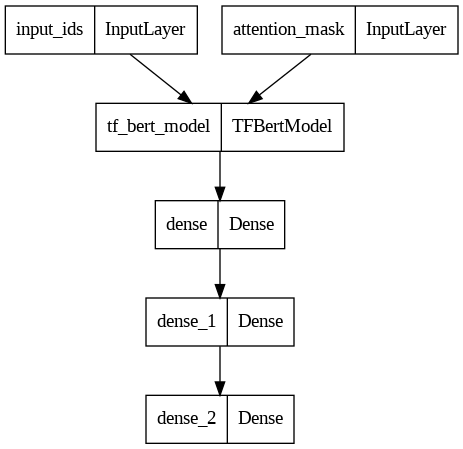

In [ ]:
keras.utils.plot_model(model)

The original authors of BERT recommended batch sizes of 16 or 32 for fine-tuning. Due to memory limitations, a batch size of 32 was chosen. Since the dataset is relatively large and with a step value per epoch of 5785, we can speed up the training.

In [ ]:
# Training
history = model.fit(
    [x_train_ids, x_train_attention],  # Input data: tokenized sequences and attention masks
    train_label_encoded,  # Labels after one-hot encoding
    batch_size=32,
    validation_data=([x_val_ids, x_val_attention] , val_label_encoded),  # Validation data
    epochs=2,
    callbacks=[mcp_save]
)

Epoch 1/2
11569/11569 [==============================] - ETA: 0s - loss: 0.4764 - categorical_accuracy: 0.8043

11569/11569 [==============================] - 14237s 1s/step - loss: 0.4764 - categorical_accuracy: 0.8043 - val_loss: 0.4095 - val_categorical_accuracy: 0.8358
Epoch 2/2
11569/11569 [==============================] - ETA: 0s - loss: 0.3455 - categorical_accuracy: 0.8668

11569/11569 [==============================] - 14211s 1s/step - loss: 0.3455 - categorical_accuracy: 0.8668 - val_loss: 0.3805 - val_categorical_accuracy: 0.8577


In [ ]:
# Training
#history = model.fit(
#    [x_train_ids, x_train_attention],  # Input data: tokenized sequences and attention masks
#    train_label_encoded,  # Labels after one-hot encoding
#    batch_size=64,
#    validation_data=([x_val_ids, x_val_attention] , val_label_encoded),  # Validation data
#    epochs=3,
#    callbacks=[mcp_save])

In [ ]:
# To load the best model
model.load_weights(checkpoint_filepath)

NameError: ignored

# Validation of our Best Model

In [ ]:
# Evaluation Best Model
score = model.evaluate([x_val_ids, x_val_attention], val_label_encoded, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.380545973777771
Test accuracy: 0.8576661348342896


In [ ]:
# Inference
yc1_pred = model.predict([x_val_ids, x_val_attention])  # Use x_val for inference, assuming it's your validation data
print('Prediction shape (probability distribution):', yc1_pred.shape)



2893/2893 [==============================] - 1174s 405ms/step
Prediction shape (probability distribution): (92550, 3)


In [ ]:
# Selection of the highest-probability class for each test sample
y1_pred = np.argmax(yc1_pred, axis=1)  # Get the predicted class index for each sample
print('Prediction shape (argmax):', y1_pred.shape)


Prediction shape (argmax): (92550,)


In [ ]:
# Now, let's compare the predicted labels with the true labels
correct_predictions = np.sum(y1_pred == val_label)  # Count the number of correct predictions
total_samples = len(val_label)  # Total number of samples in the validation set
accuracy = correct_predictions / total_samples  # Calculate accuracy
print('Accuracy:', accuracy)

Accuracy: 0.8576661264181523


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Assuming val_label is a 1D array of class labels (not one-hot encoded)
y_test = val_label

# Classification report
print('Classification report:')
print(classification_report(y_test, y1_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      8470
           1       0.81      0.65      0.72     24678
           2       0.88      0.96      0.92     59402

    accuracy                           0.86     92550
   macro avg       0.83      0.79      0.81     92550
weighted avg       0.85      0.86      0.85     92550



# Prediction on new Data: "tbl_labelled_reviews"

In [ ]:
# Extract file: tbl_customer_review
t0 = time()
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_customer_reviews.csv')
print("File extraction completed in %0.3f seconds" % (time() - t0))

File extraction completed in 2.423 seconds


In [ ]:
# File path of the extracted 'tbl_customers.csv' file
csv_file_path = "tbl_customer_reviews.csv"
tbl_customer_reviews = pd.read_csv(csv_file_path)

In [ ]:
tbl_customer_reviews

,Unnamed: 0,review_id,customer_id,review_text
0,0,1,814256,I have bought several of the Vitality canned d...
1,1,2,457475,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,104045,This is a confection that has been around a fe...
3,3,4,603662,If you are looking for the secret ingredient i...
4,4,5,739314,Great taffy at a great price. There was a wid...
...,...,...,...,...
105705,105705,140942,224091,"We Love,Love our Keurig coffee maker .My husba..."
105706,105706,140943,196666,This is supposed to be a light roast coffee bu...
105707,105707,140944,618226,I have always been happy with my Kcups but thi...
105708,105708,140945,844918,I ordered light roast coffee and was sent one ...


In [ ]:
def custom_standardization(input_data):
    # Convert to lowercase
    lowercase = input_data.lower()

    # Remove URLs
    without_urls = re.sub(r'http\S+', ' ', lowercase)

    # Remove HTML tags like "<br />"
    stripped_html = re.sub("<br\s*/?>", " ", without_urls)


    # Remove punctuation
    punctuation_regex = f"[{re.escape(string.punctuation)}]"
    cleaned_text = re.sub(punctuation_regex, "", stripped_html)
    # Remove numbers
    cleaned_text = re.sub(r'\d+', '', cleaned_text)

    # Remove sequences containing digits and word characters
    cleaned_text = re.sub(r'\w*\d\w*', '', cleaned_text)

    return cleaned_text

# Assuming "review_text" is the column containing the review text
tbl_customer_reviews['review_text_cleaned'] = tbl_customer_reviews['review_text'].apply(custom_standardization)
# Remove stop words for each review_text_cleaned
stop = stopwords.words('english')


tbl_customer_reviews['review_text_cleaned'] = tbl_customer_reviews['review_text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
tbl_customer_reviews

,Unnamed: 0,review_id,customer_id,review_text,review_text_cleaned
0,0,1,814256,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,1,2,457475,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...
2,2,3,104045,This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,3,4,603662,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,4,5,739314,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...
...,...,...,...,...,...
105705,105705,140942,224091,"We Love,Love our Keurig coffee maker .My husba...",lovelove keurig coffee maker husband lives bre...
105706,105706,140943,196666,This is supposed to be a light roast coffee bu...,supposed light roast coffee states extra bold ...
105707,105707,140944,618226,I have always been happy with my Kcups but thi...,always happy kcups particular box good made cu...
105708,105708,140945,844918,I ordered light roast coffee and was sent one ...,ordered light roast coffee sent one box light ...


In [ ]:
preprocessed_text = tbl_customer_reviews['review_text_cleaned']

In [ ]:
preprocessed_text

0         bought several vitality canned dog food produc...
1         product arrived labeled jumbo salted peanutsth...
2         confection around centuries light pillowy citr...
3         looking secret ingredient robitussin believe f...
4         great taffy great price wide assortment yummy ...
                                ...                        
105705    lovelove keurig coffee maker husband lives bre...
105706    supposed light roast coffee states extra bold ...
105707    always happy kcups particular box good made cu...
105708    ordered light roast coffee sent one box light ...
105709    love ease use speed keurig brewer variety kcup...
Name: review_text_cleaned, Length: 105710, dtype: object

In [ ]:
# Encode the 'review_text' using the same tokenizer and maxlen
x_review_ids, x_review_attention = fast_encode(preprocessed_text, tokenizer, maxlen=180)


In [ ]:
# Make predictions using the trained model
predicted_probabilities = model.predict([x_review_ids, x_review_attention])


3304/3304 [==============================] - 1290s 390ms/step


In [ ]:
# Assuming you have a function to inverse-transform one-hot encoded predictions
predicted_labels = np.argmax(predicted_probabilities, axis=1)
predicted_labels

array([2, 1, 2, ..., 0, 1, 1])

In [ ]:
# Merge 'predicted_labels' with 'tbl_customer_reviews' based on a common index or identifier
tbl_customer_reviews['sentiment_of_review'] =predicted_labels

In [ ]:
tbl_customer_reviews= tbl_customer_reviews.loc[:, ~tbl_customer_reviews.columns.isin(['Unnamed: 0'])]

In [ ]:
# There are no duplicate (sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0})
tbl_customer_reviews

,review_id,customer_id,review_text,review_text_cleaned,sentiment_of_review
0,1,814256,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,2
1,2,457475,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanutsthe peanuts actually small sized unsalted sure error vendor intended represent product jumbo,1
2,3,104045,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.",confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story cs lewis lion witch wardrobe treat seduces edmund selling brother sisters witch,2
3,4,603662,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.,looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal,1
4,5,739314,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,2
...,...,...,...,...,...
105705,140942,224091,"We Love,Love our Keurig coffee maker .My husband lives and breathes coffee and would rather have coffee at home than at store and he makes it himself .He perfers regular and I get the decaf.",lovelove keurig coffee maker husband lives breathes coffee would rather coffee home store makes perfers regular get decaf,2
105706,140943,196666,This is supposed to be a light roast coffee but it states extra bold on the label. How can a light roast coffee be extra bold. The outside of the box does not state that it is extra bold it only says light roast. Threw the entire box in the garbage after I tasted the first cup. Did not want to be bothered with returns.,supposed light roast coffee states extra bold label light roast coffee extra bold outside box state extra bold says light roast threw entire box garbage tasted first cup want bothered returns,0
105707,140944,618226,"I have always been happy with my Kcups but this particular box is not good! I made a cup and it was FULL of grinds, i thought maybe it was just that one so i made another....FULL of grinds. I can't use them!",always happy kcups particular box good made cup full grinds thought maybe one made anotherfull grinds cant use,0
105708,140945,844918,I ordered light roast coffee and was sent one box of light roast and one box of extra bold. I didn't notice the error until I had used a couple of the extra bold pods. Way too strong for me and I am very disappointed. The light roast was really good.,ordered light roast coffee sent one box light roast one box extra bold didnt notice error used couple extra bold pods way strong disappointed light roast really good,1


In [ ]:
# Identify duplicate rows
duplicates = tbl_customer_reviews[tbl_customer_reviews.duplicated()]

# Display duplicate rows
print(duplicates)

Empty DataFrame
Columns: [review_id, customer_id, review_text, review_text_cleaned, sentiment_of_review]
Index: []


In [ ]:
# Negative text_reviews
pd.set_option('display.max_colwidth', -1)
negatives_rev= tbl_customer_reviews[tbl_customer_reviews['sentiment_of_review'] == 0	]['review_text']
negatives_rev

<ipython-input-79-0278ccb6c66c>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


34        This is the same stuff you can buy at the big box stores.  There is nothing healthy about it.  It is just carbs and sugars.  Save your money and get something that at least has some taste.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
# ...neutral...
pd.set_option('display.max_colwidth', -1)
neutral_rev= tbl_customer_reviews[tbl_customer_reviews['sentiment_of_review'] == 1	]['review_text']
neutral_rev

<ipython-input-80-7810214017e4>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


1         Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".                                                                                                                                                                                                                                                                                                                                                                                                        
3         If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal.                                                                                                                                                                                  

In [ ]:
# ...and positive
pd.set_option('display.max_colwidth', -1)
positive_rev= tbl_customer_reviews[tbl_customer_reviews['sentiment_of_review'] == 2	]['review_text']
positive_rev

<ipython-input-81-d6d8be75d01b>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


0         I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.                                                                                                                                                                                                                                                      
2         This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling ou

# Export dataset

In [ ]:
# Export the new dataset
tbl_customer_reviews.to_csv('tbl_customer_reviews.csv')
!cp tbl_customer_reviews.csv "drive/My Drive/marketing analytics"

# Analysis

In [ ]:
sentiment_count= tbl_customer_reviews.groupby('sentiment_of_review', as_index=False)['customer_id'].count()
sentiment_count

,sentiment_of_review,customer_id
0,0,9490
1,1,23849
2,2,72371


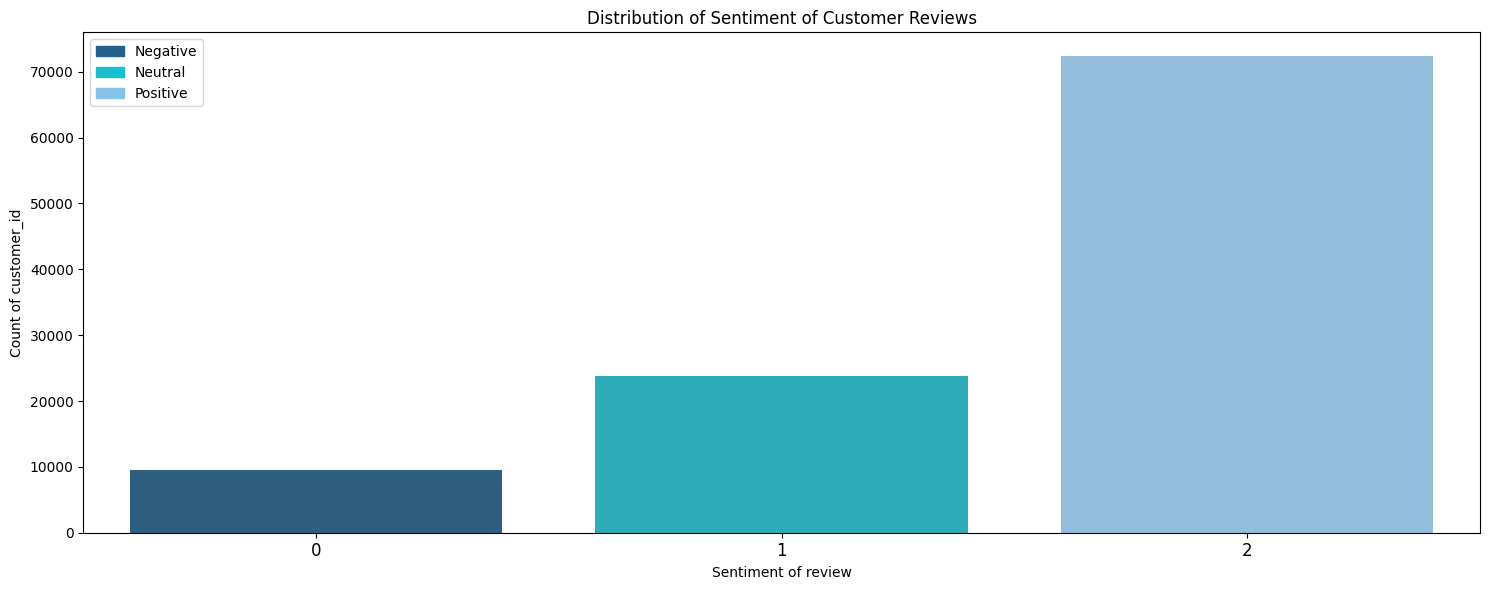

In [ ]:
# Set the figure size
plt.figure(figsize=(15, 6))

# Define a custom color palette for the sentiments
colors = ['#21618C', '#17becf', '#85C1E9']

# Create the bar plot using Seaborn with the custom color palette
ax = sns.barplot(data=sentiment_count, x='sentiment_of_review', y='customer_id', palette=colors)

# Customize the plot
plt.xlabel('Sentiment of review')
plt.ylabel('Count of customer_id')
plt.title('Distribution of Sentiment of Customer Reviews')
plt.xticks(fontsize=12)

# Define the legend labels and handles
legend_labels = ['Negative', 'Neutral', 'Positive']
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], label=label) for i, label in enumerate(legend_labels)]

# Add a legend with labels
ax.legend(handles=handles, labels=legend_labels)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
source_path = "/content/drive/MyDrive/marketing analytics/file aggiornati.zip"

In [ ]:
# Extract file: tbl_customer_review
t0 = time()
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_customer_reviews.csv')
print("File extraction completed in %0.3f seconds" % (time() - t0))

File extraction completed in 2.266 seconds


In [ ]:
# File path of the extracted 'tbl_customers.csv' file
csv_file_path = "tbl_customer_reviews.csv"
tbl_customer_reviews = pd.read_csv(csv_file_path)

In [ ]:
tbl_customer_reviews

,Unnamed: 0,review_id,customer_id,review_text,review_text_cleaned,sentiment_of_review
0,0,1,814256,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,2
1,1,2,457475,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,1
2,2,3,104045,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,2
3,3,4,603662,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,1
4,4,5,739314,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,2
...,...,...,...,...,...,...
105705,105705,140942,224091,"We Love,Love our Keurig coffee maker .My husba...",lovelove keurig coffee maker husband lives bre...,2
105706,105706,140943,196666,This is supposed to be a light roast coffee bu...,supposed light roast coffee states extra bold ...,0
105707,105707,140944,618226,I have always been happy with my Kcups but thi...,always happy kcups particular box good made cu...,0
105708,105708,140945,844918,I ordered light roast coffee and was sent one ...,ordered light roast coffee sent one box light ...,1


In [ ]:
# Filter rows where the sentiment_label is equal to 'positive'
positive_reviews = tbl_customer_reviews.loc[tbl_customer_reviews['sentiment_of_review'] == 2, 'review_text_cleaned']

# Concatenate all positive reviews into a single string
text = ' '.join(positive_reviews)

In [ ]:
text

Output hidden; open in https://colab.research.google.com to view.